In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sys
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.base import clone
import time
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import math
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path
import os
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.linear_model import SGDClassifier
import statsmodels.api as sm
from sklearn.model_selection import RandomizedSearchCV


In [2]:
# import data that has already been preprocessed
X_train = pd.read_csv('X_train.csv',index_col=0)
y_train = pd.read_csv('y_train.csv',index_col=0)
X_test = pd.read_csv('X_test.csv',index_col=0)
y_test = pd.read_csv('y_test.csv',index_col=0)
X_train.head()

,Patient_age,Genes_mother_side,Inherited_father,Maternal_gene,Paternal_gene,Blood_cell_count,Status,Respiratory_rate,Heart_rate,Follow_up,...,History_previous_pregnancies,Previous_abortions,Birth_defects,White_blood_cell_count,Blood_test,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5
13647,-1.189643,0.852120,1.487100,0.589244,0.504979,-1.725400,0.961214,-0.802729,-0.669551,-0.928280,...,-0.011244,-0.382844,-0.394093,-2.016210,1.179975,0.901598,1.177452,-2.068385,-1.643148,-1.565422
16490,-1.428746,-0.370583,-0.743214,-0.985130,0.359504,1.292550,-0.331315,-0.624397,-0.607944,1.677702,...,-0.214748,-0.556007,0.388358,-0.578357,-1.513910,1.763845,-0.765864,0.875969,1.495916,-1.228400
4638,-0.472331,-0.352353,-0.743214,-1.775636,0.504979,0.468095,0.961214,-0.832332,-0.669551,0.125815,...,-0.011244,-0.917426,-1.597768,-0.419822,1.179975,0.901598,-1.088203,-2.068385,0.452145,-1.565422
1364,0.723188,0.063834,1.487100,-1.424639,-0.904261,0.417500,-0.467394,-0.138618,-1.459780,-0.294799,...,1.772549,1.818042,1.494336,0.190584,-0.588865,-0.511990,-0.631469,-0.266679,-0.384075,0.932942
15165,0.484084,0.614918,1.487100,-0.416620,1.683296,0.927449,1.415094,0.294454,0.847785,1.138934,...,1.185632,0.161856,1.692602,-0.541987,-1.143906,0.413652,-0.763680,0.562028,0.785125,0.394824


In [3]:
y_test.value_counts()

Genetic_disorder
0                   2041
2                   1533
1                    414
Name: count, dtype: int64

## class balance

In [4]:
print(f'\ntarget class fractional balance:\n{y_train.value_counts(normalize=True)}', sep='')


target class fractional balance:
Genetic_disorder
0                   0.511694
2                   0.384413
1                   0.103894
Name: proportion, dtype: float64


## Train/val split

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.20, random_state=42, shuffle=True,stratify=y_train)
print ('Train observations: %d\nvalidation observations: %d' % (X_train.shape[0], X_val.shape[0]))

Train observations: 12759
validation observations: 3190


## Logistric regression

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [7]:
lr_params = {"multi_class": ["ovr", "multinomial", "auto"]}

In [8]:
lr_pipeline = Pipeline([
    ("lr", GridSearchCV(LogisticRegression(max_iter=1000), lr_params, verbose=3)),
])


In [9]:
# Fit and evaluate initial Logistic Regression model
lr_pipeline.fit(X_train, y_train.values.ravel())
val_pred_lr = lr_pipeline.predict(X_val)
print("Initial Logistic Regression Classification Report:")
print(classification_report(y_val, val_pred_lr))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................multi_class=ovr;, score=0.517 total time=   0.7s
[CV 2/5] END ...................multi_class=ovr;, score=0.514 total time=   0.0s
[CV 3/5] END ...................multi_class=ovr;, score=0.511 total time=   0.0s
[CV 4/5] END ...................multi_class=ovr;, score=0.519 total time=   0.0s
[CV 5/5] END ...................multi_class=ovr;, score=0.519 total time=   0.0s
[CV 1/5] END ...........multi_class=multinomial;, score=0.521 total time=   0.0s
[CV 2/5] END ...........multi_class=multinomial;, score=0.516 total time=   0.0s
[CV 3/5] END ...........multi_class=multinomial;, score=0.512 total time=   0.0s
[CV 4/5] END ...........multi_class=multinomial;, score=0.523 total time=   0.0s
[CV 5/5] END ...........multi_class=multinomial;, score=0.520 total time=   0.0s
[CV 1/5] END ..................multi_class=auto;, score=0.521 total time=   0.0s
[CV 2/5] END ..................multi_class=auto;,

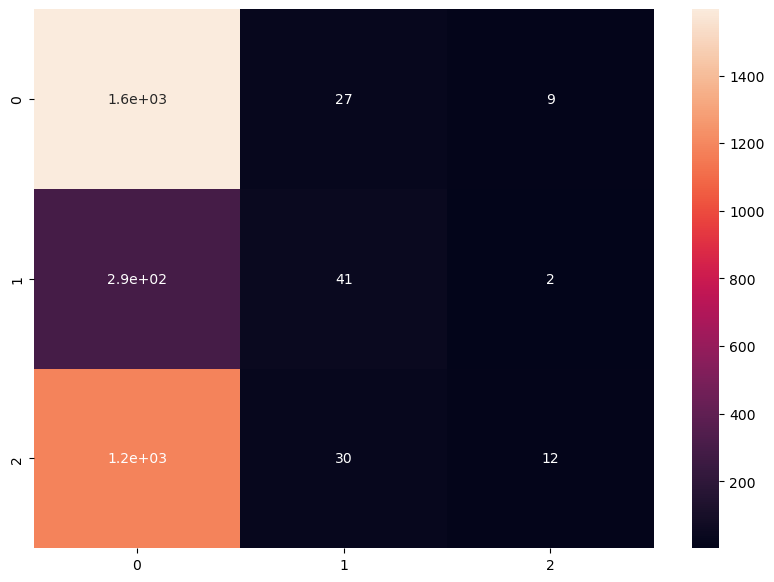

In [10]:
df_cm = confusion_matrix(y_val, val_pred_lr)
plt.figure(figsize=(10,7))

# Plot the heatmap using seaborn
sns.heatmap(df_cm, annot=True)

# Display the plot
plt.show()

## Perform N-fold Cross-Validation

In [11]:
from sklearn.model_selection import cross_val_score

lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train.values.ravel(), cv=5)
lr_mean_score = np.mean(lr_cv_scores)
lr_std_score = np.std(lr_cv_scores)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ...................multi_class=ovr;, score=0.518 total time=   0.0s
[CV 2/5] END ...................multi_class=ovr;, score=0.508 total time=   0.1s
[CV 3/5] END ...................multi_class=ovr;, score=0.515 total time=   0.0s
[CV 4/5] END ...................multi_class=ovr;, score=0.520 total time=   0.1s
[CV 5/5] END ...................multi_class=ovr;, score=0.516 total time=   0.0s
[CV 1/5] END ...........multi_class=multinomial;, score=0.514 total time=   0.0s
[CV 2/5] END ...........multi_class=multinomial;, score=0.511 total time=   0.0s
[CV 3/5] END ...........multi_class=multinomial;, score=0.516 total time=   0.0s
[CV 4/5] END ...........multi_class=multinomial;, score=0.523 total time=   0.0s
[CV 5/5] END ...........multi_class=multinomial;, score=0.515 total time=   0.0s
[CV 1/5] END ..................multi_class=auto;, score=0.514 total time=   0.0s
[CV 2/5] END ..................multi_class=auto;,

In [12]:
data = {
    'Model': ['Logistic Regression'],
    'Mean Score': [lr_mean_score],
    'Std Score': [lr_std_score]
}

performance_df = pd.DataFrame(data)

# Display the performance DataFrame
print("Performance Metrics:")
performance_df

Performance Metrics:


,Model,Mean Score,Std Score
0,Logistic Regression,0.518536,0.003803


## Analyze the most significant attributes for LR

In [13]:
best_lr_model = lr_pipeline.named_steps['lr'].best_estimator_

# Extract feature importance for logistic regression
lr_feature_importance = best_lr_model.coef_

In [14]:
# Create a DataFrame for feature importance
lr_feature_names = X_train.columns  
feature_importance_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Logistic Regression': lr_feature_importance[0]
})

# Display the feature importance DataFrame
print("\nFeature Importance:")
feature_importance_df


Feature Importance:


,Feature,Logistic Regression
0,Patient_age,-0.004569
1,Genes_mother_side,0.016161
2,Inherited_father,-0.008715
3,Maternal_gene,-0.007977
4,Paternal_gene,0.080980
5,Blood_cell_count,0.098078
6,Status,0.047473
7,Respiratory_rate,-0.039249
8,Heart_rate,0.016755
9,Follow_up,-0.009937


## Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:
dt_params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
}
dt = Pipeline(
    [
        ("Bayes", GridSearchCV(DecisionTreeClassifier(), dt_params, verbose=3)),
    ]
)

In [17]:
dt.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....criterion=gini, splitter=best;, score=0.499 total time=   0.3s
[CV 2/5] END .....criterion=gini, splitter=best;, score=0.458 total time=   0.4s
[CV 3/5] END .....criterion=gini, splitter=best;, score=0.466 total time=   0.4s
[CV 4/5] END .....criterion=gini, splitter=best;, score=0.465 total time=   0.4s
[CV 5/5] END .....criterion=gini, splitter=best;, score=0.474 total time=   0.4s
[CV 1/5] END ...criterion=gini, splitter=random;, score=0.470 total time=   0.1s
[CV 2/5] END ...criterion=gini, splitter=random;, score=0.467 total time=   0.1s
[CV 3/5] END ...criterion=gini, splitter=random;, score=0.471 total time=   0.5s
[CV 4/5] END ...criterion=gini, splitter=random;, score=0.457 total time=   0.2s
[CV 5/5] END ...criterion=gini, splitter=random;, score=0.479 total time=   0.1s
[CV 1/5] END ..criterion=entropy, splitter=best;, score=0.482 total time=   0.5s
[CV 2/5] END ..criterion=entropy, splitter=best;,

Pipeline(steps=[('Bayes',
                 GridSearchCV(estimator=DecisionTreeClassifier(),
                              param_grid={'criterion': ['gini', 'entropy',
                                                        'log_loss'],
                                          'splitter': ['best', 'random']},
                              verbose=3))])

In [18]:
pred_val_dt = dt.predict(X_val)

In [19]:
print(classification_report(y_val, pred_val_dt))

              precision    recall  f1-score   support

           0       0.56      0.56      0.56      1632
           1       0.26      0.28      0.27       332
           2       0.41      0.40      0.40      1226

    accuracy                           0.47      3190
   macro avg       0.41      0.41      0.41      3190
weighted avg       0.47      0.47      0.47      3190



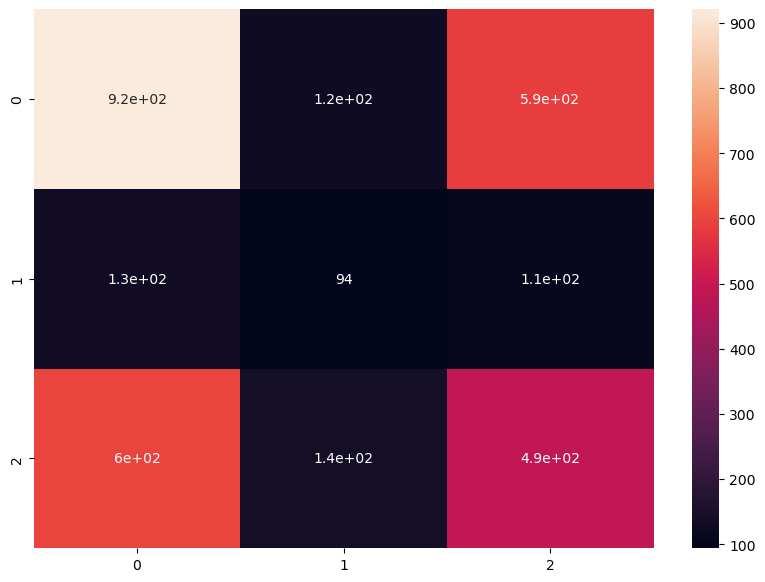

In [20]:
df_cm = confusion_matrix(y_val, pred_val_dt)
plt.figure(figsize=(10,7))

# Plot the heatmap using seaborn
sns.heatmap(df_cm, annot=True)

# Display the plot
plt.show()

## Perform N-fold Cross-Validation

In [21]:
dt_cv_scores = cross_val_score(dt, X_train, y_train.values.ravel(), cv=5)
dt_mean_score = np.mean(dt_cv_scores)
dt_std_score = np.std(dt_cv_scores)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .....criterion=gini, splitter=best;, score=0.470 total time=   1.9s
[CV 2/5] END .....criterion=gini, splitter=best;, score=0.465 total time=   3.1s
[CV 3/5] END .....criterion=gini, splitter=best;, score=0.472 total time=   3.4s
[CV 4/5] END .....criterion=gini, splitter=best;, score=0.478 total time=   2.1s
[CV 5/5] END .....criterion=gini, splitter=best;, score=0.463 total time=   0.2s
[CV 1/5] END ...criterion=gini, splitter=random;, score=0.455 total time=   0.0s
[CV 2/5] END ...criterion=gini, splitter=random;, score=0.459 total time=   0.1s
[CV 3/5] END ...criterion=gini, splitter=random;, score=0.479 total time=   0.1s
[CV 4/5] END ...criterion=gini, splitter=random;, score=0.464 total time=   0.1s
[CV 5/5] END ...criterion=gini, splitter=random;, score=0.449 total time=   0.1s
[CV 1/5] END ..criterion=entropy, splitter=best;, score=0.458 total time=   0.3s
[CV 2/5] END ..criterion=entropy, splitter=best;,

[CV 4/5] END ...criterion=gini, splitter=random;, score=0.483 total time=   0.3s
[CV 5/5] END ...criterion=gini, splitter=random;, score=0.491 total time=   0.0s
[CV 1/5] END ..criterion=entropy, splitter=best;, score=0.484 total time=   2.1s
[CV 2/5] END ..criterion=entropy, splitter=best;, score=0.476 total time=   2.3s
[CV 3/5] END ..criterion=entropy, splitter=best;, score=0.472 total time=   1.2s
[CV 4/5] END ..criterion=entropy, splitter=best;, score=0.499 total time=   0.8s
[CV 5/5] END ..criterion=entropy, splitter=best;, score=0.468 total time=   0.4s
[CV 1/5] END criterion=entropy, splitter=random;, score=0.487 total time=   0.1s
[CV 2/5] END criterion=entropy, splitter=random;, score=0.465 total time=   0.3s
[CV 3/5] END criterion=entropy, splitter=random;, score=0.485 total time=   0.2s
[CV 4/5] END criterion=entropy, splitter=random;, score=0.472 total time=   1.8s
[CV 5/5] END criterion=entropy, splitter=random;, score=0.472 total time=   1.7s
[CV 1/5] END .criterion=log_

In [22]:
data = {
    'Model': ['Logistic Regression','Decision Tree'],
    'Mean Score': [lr_mean_score, dt_mean_score],
    'Std Score': [lr_std_score, dt_std_score]
}

performance_df = pd.DataFrame(data)

# Display the performance DataFrame
print("Performance Metrics:")
performance_df

Performance Metrics:


,Model,Mean Score,Std Score
0,Logistic Regression,0.518536,0.003803
1,Decision Tree,0.478879,0.012693


## Analyze the most significant attributes for DT

In [23]:
best_dt_model = dt.named_steps['Bayes'].best_estimator_

# Extract feature importance for decision tree
dt_feature_importance = best_dt_model.feature_importances_

In [24]:
feature_importance_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Logistic Regression': lr_feature_importance[0],
    'Decision Tree': dt_feature_importance
})

# Display the feature importance DataFrame
print("\nFeature Importance:")
feature_importance_df


Feature Importance:


,Feature,Logistic Regression,Decision Tree
0,Patient_age,-0.004569,0.080250
1,Genes_mother_side,0.016161,0.133978
2,Inherited_father,-0.008715,0.049623
3,Maternal_gene,-0.007977,0.134706
4,Paternal_gene,0.080980,0.033609
5,Blood_cell_count,0.098078,0.024936
6,Status,0.047473,0.032142
7,Respiratory_rate,-0.039249,0.029664
8,Heart_rate,0.016755,0.028252
9,Follow_up,-0.009937,0.026547


## Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
rand = Pipeline(
    [("rand", RandomForestClassifier(criterion="gini"))]
)

In [27]:
rand.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('rand', RandomForestClassifier())])

In [28]:
pred_val_rf = rand.predict(X_val)

In [29]:
print(classification_report(y_val, pred_val_rf))

              precision    recall  f1-score   support

           0       0.57      0.82      0.67      1632
           1       0.49      0.17      0.25       332
           2       0.50      0.30      0.37      1226

    accuracy                           0.55      3190
   macro avg       0.52      0.43      0.43      3190
weighted avg       0.53      0.55      0.51      3190



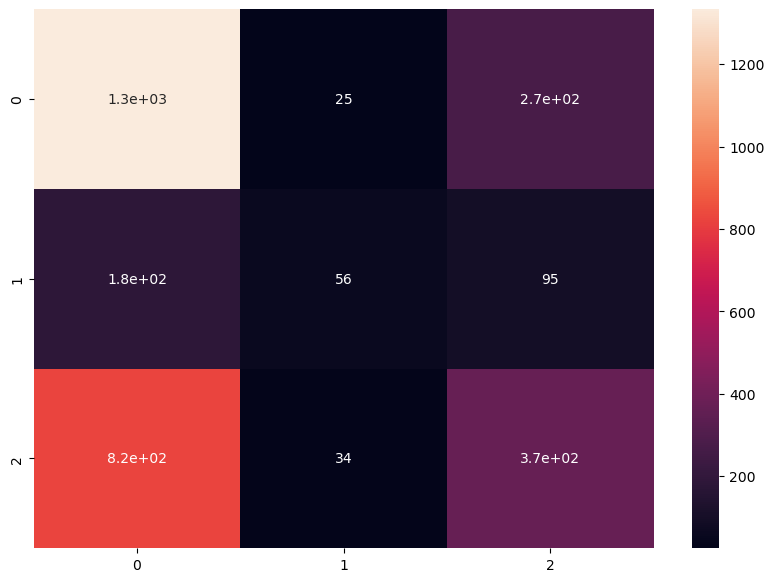

In [30]:
df_cm = confusion_matrix(y_val, pred_val_rf)
plt.figure(figsize=(10,7))

# Plot the heatmap using seaborn
sns.heatmap(df_cm, annot=True)

# Display the plot
plt.show()

In [31]:
rf_cv_scores = cross_val_score(rand, X_train, y_train.values.ravel(), cv=5)
rf_mean_score = np.mean(rf_cv_scores)
rf_std_score = np.std(rf_cv_scores)

In [32]:
data = {
    'Model': ['Logistic Regression','Decision Tree','Random Forest'],
    'Mean Score': [lr_mean_score, dt_mean_score, rf_mean_score],
    'Std Score': [lr_std_score, dt_std_score, rf_std_score]
}

performance_df = pd.DataFrame(data)

# Display the performance DataFrame
print("Performance Metrics:")
performance_df

Performance Metrics:


,Model,Mean Score,Std Score
0,Logistic Regression,0.518536,0.003803
1,Decision Tree,0.478879,0.012693
2,Random Forest,0.546907,0.009233


In [33]:
rf_model = rand.named_steps['rand']
rf_feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Logistic Regression': lr_feature_importance[0],
    'Decision Tree': dt_feature_importance,
    'Random Forest': rf_feature_importance
})

# Display the feature importance DataFrame
print("\nFeature Importance:")
feature_importance_df


Feature Importance:


,Feature,Logistic Regression,Decision Tree,Random Forest
0,Patient_age,-0.004569,0.080250,0.083984
1,Genes_mother_side,0.016161,0.133978,0.114947
2,Inherited_father,-0.008715,0.049623,0.056218
3,Maternal_gene,-0.007977,0.134706,0.107367
4,Paternal_gene,0.080980,0.033609,0.028479
5,Blood_cell_count,0.098078,0.024936,0.026946
6,Status,0.047473,0.032142,0.028818
7,Respiratory_rate,-0.039249,0.029664,0.033540
8,Heart_rate,0.016755,0.028252,0.032550
9,Follow_up,-0.009937,0.026547,0.032924


## Gaussian Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

In [35]:
gnb = Pipeline([("GNB", GaussianNB())])

In [36]:
gnb.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('GNB', GaussianNB())])

In [37]:
pred_val_gnb = gnb.predict(X_val)

In [38]:
print(classification_report(y_val, pred_val_gnb))

              precision    recall  f1-score   support

           0       0.53      0.96      0.68      1632
           1       0.40      0.18      0.25       332
           2       0.52      0.03      0.06      1226

    accuracy                           0.52      3190
   macro avg       0.48      0.39      0.33      3190
weighted avg       0.51      0.52      0.40      3190



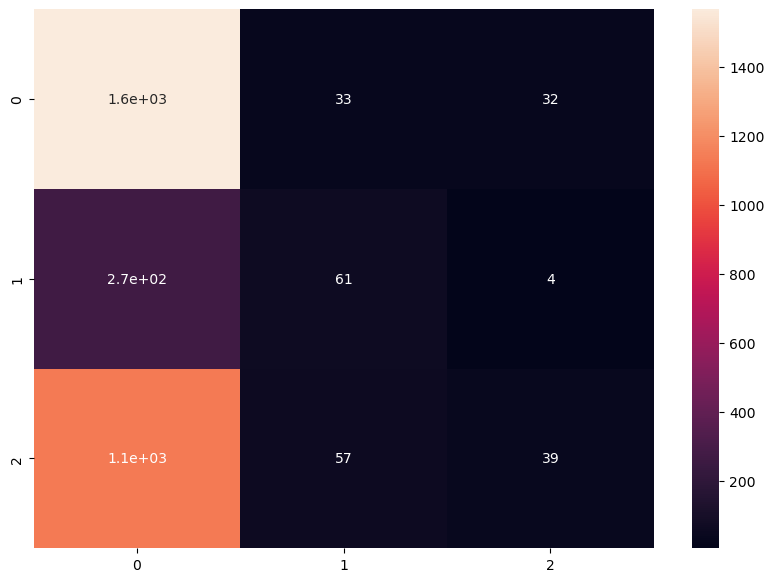

In [39]:
df_cm = confusion_matrix(y_val, pred_val_gnb)
plt.figure(figsize=(10,7))

# Plot the heatmap using seaborn
sns.heatmap(df_cm, annot=True)

# Display the plot
plt.show()

In [40]:
gnb_cv_scores = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=5)
gnb_mean_score = np.mean(gnb_cv_scores)
gnb_std_score = np.std(gnb_cv_scores)

In [41]:
data = {
    'Model': ['Logistic Regression','Decision Tree','Random Forest','Gaussian Naive Bayes'],
    'Mean Score': [lr_mean_score, dt_mean_score, rf_mean_score, gnb_mean_score],
    'Std Score': [lr_std_score, dt_std_score, rf_std_score, gnb_std_score]
}

performance_df = pd.DataFrame(data)

# Display the performance DataFrame
print("Performance Metrics:")
performance_df

Performance Metrics:


,Model,Mean Score,Std Score
0,Logistic Regression,0.518536,0.003803
1,Decision Tree,0.478879,0.012693
2,Random Forest,0.546907,0.009233
3,Gaussian Naive Bayes,0.519085,0.003184


## XGBoost

In [42]:
from xgboost import XGBClassifier

In [43]:
xgb = Pipeline([
    ('xgb', XGBClassifier())
])

In [44]:
xgb.fit(X_train, y_train.values.ravel())

# Make predictions on the validation set
pred_val_xgb = xgb.predict(X_val)

In [45]:
print(classification_report(y_val, pred_val_xgb))

              precision    recall  f1-score   support

           0       0.58      0.74      0.65      1632
           1       0.45      0.30      0.36       332
           2       0.48      0.34      0.40      1226

    accuracy                           0.54      3190
   macro avg       0.50      0.46      0.47      3190
weighted avg       0.53      0.54      0.52      3190



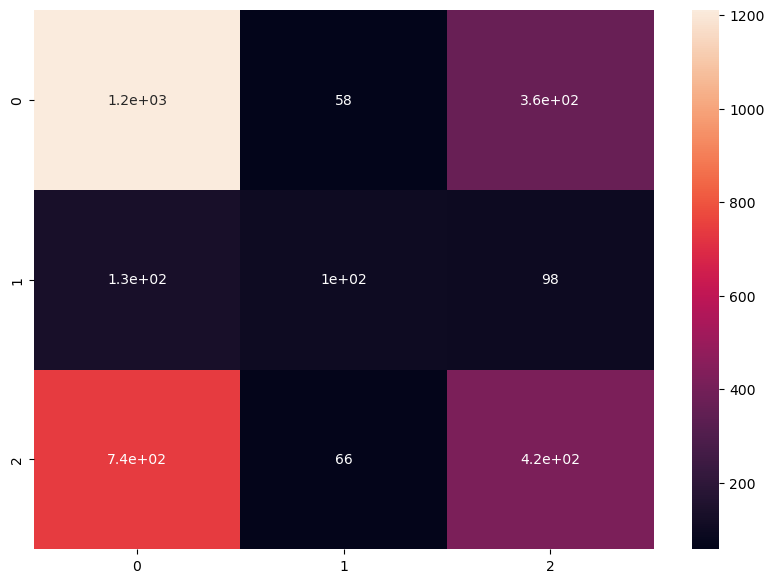

In [46]:
df_cm = confusion_matrix(y_val, pred_val_xgb)
plt.figure(figsize=(10,7))

# Plot the heatmap using seaborn
sns.heatmap(df_cm, annot=True)

# Display the plot
plt.show()

In [47]:
xgb_cv_scores = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=5)
xgb_mean_score = np.mean(xgb_cv_scores)
xgb_std_score = np.std(xgb_cv_scores)

In [48]:
data = {
    'Model': ['Logistic Regression','Decision Tree','Random Forest','Gaussian Naive Bayes','XGBoost'],
    'Mean Score': [lr_mean_score, dt_mean_score, rf_mean_score, gnb_mean_score, xgb_mean_score],
    'Std Score': [lr_std_score, dt_std_score, rf_std_score, gnb_std_score, xgb_std_score]
}

performance_df = pd.DataFrame(data)

# Display the performance DataFrame
print("Performance Metrics:")
performance_df

Performance Metrics:


,Model,Mean Score,Std Score
0,Logistic Regression,0.518536,0.003803
1,Decision Tree,0.478879,0.012693
2,Random Forest,0.546907,0.009233
3,Gaussian Naive Bayes,0.519085,0.003184
4,XGBoost,0.522925,0.013151


In [49]:
xgb_model = xgb.named_steps['xgb']
xgb_feature_importance = xgb_model.feature_importances_

In [50]:
feature_importance_df = pd.DataFrame({
    'Feature': lr_feature_names,
    'Logistic Regression': lr_feature_importance[0],
    'Decision Tree': dt_feature_importance,
    'Random Forest': rf_feature_importance,
    'XGBoost':xgb_feature_importance
})

# Display the feature importance DataFrame
print("\nFeature Importance:")
feature_importance_df


Feature Importance:


,Feature,Logistic Regression,Decision Tree,Random Forest,XGBoost
0,Patient_age,-0.004569,0.080250,0.083984,0.031886
1,Genes_mother_side,0.016161,0.133978,0.114947,0.033299
2,Inherited_father,-0.008715,0.049623,0.056218,0.030930
3,Maternal_gene,-0.007977,0.134706,0.107367,0.034186
4,Paternal_gene,0.080980,0.033609,0.028479,0.047533
5,Blood_cell_count,0.098078,0.024936,0.026946,0.048638
6,Status,0.047473,0.032142,0.028818,0.041198
7,Respiratory_rate,-0.039249,0.029664,0.033540,0.036442
8,Heart_rate,0.016755,0.028252,0.032550,0.033461
9,Follow_up,-0.009937,0.026547,0.032924,0.035319
